<a href="https://colab.research.google.com/github/Rishikesh23a/Deepfake-Image-Detection/blob/main/Copy_of_ANNA(deepfake_image_detection)project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab cell 1
# install mtcnn (face detector) and tensorflow
!pip install -q mtcnn


In [ ]:
# Colab cell 2
# This cell tries to find a local archive at common paths (/mnt/data, /content).
# If not found it will show an upload widget so you can upload archive.zip manually.
import os, zipfile, shutil
from google.colab import files

POSSIBLE_PATHS = [
    '/mnt/data/archive.zip',   # when user uploaded via notebook environment
    '/content/archive.zip',
    '/content/rvf10k.zip',
    '/content/RVF10K.zip',
    '/content/rvf10k_raw.zip',
]

zip_path = None
for p in POSSIBLE_PATHS:
    if os.path.exists(p):
        zip_path = p
        print("Found archive at:", zip_path)
        break

if zip_path is None:
    print("No archive found automatically. Please upload your dataset .zip now (choose the RVF10K or archive.zip file).")
    uploaded = files.upload()
    if not uploaded:
        raise SystemExit("No file uploaded. Re-run this cell and upload the dataset zip.")
    # take the first uploaded filename
    zip_path = list(uploaded.keys())[0]
    print("Uploaded:", zip_path)

# extract to /content/rvf10k_raw (delete existing folder to avoid mixups)
EXTRACT_DIR = '/content/rvf10k_raw'
if os.path.exists(EXTRACT_DIR):
    print("Removing existing", EXTRACT_DIR)
    shutil.rmtree(EXTRACT_DIR)

print("Extracting", zip_path, "->", EXTRACT_DIR, " (this can take a few minutes)")
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(EXTRACT_DIR)

print("Extraction done.")
print("Top-level contents:", os.listdir(EXTRACT_DIR))


No archive found automatically. Please upload your dataset .zip now (choose the RVF10K or archive.zip file).


Saving archive.zip to archive.zip
Uploaded: archive.zip
Extracting archive.zip -> /content/rvf10k_raw  (this can take a few minutes)
Extraction done.
Top-level contents: ['rvf10k', 'valid.csv', 'train.csv']


In [ ]:
# Colab cell 3
import os, glob, pprint

BASE = '/content/rvf10k_raw'
# walk and print directories with counts
candidates = {}
for root, dirs, files in os.walk(BASE):
    for d in dirs:
        dn = d.lower()
        if dn in ('real','fake'):
            path = os.path.join(root,d)
            candidates[dn] = path

print("Found class folders automatically:")

pprint.pprint(candidates)

# If not found, show immediate children to help user fix structure
if not candidates:
    print("\nCould not find 'real'/'fake' subfolders automatically. Top-level listing:")
    print(os.listdir(BASE))
    print("\nIf your images are in a nested folder, either move them into /content/rvf10k_raw/real and /content/rvf10k_raw/fake or tell me and I'll adapt.")
else:
    print("\nCounts:")
    for k,v in candidates.items():
        print(k, "->", len(glob.glob(os.path.join(v, '*'))), "files")


Found class folders automatically:
{'fake': '/content/rvf10k_raw/rvf10k/valid/fake',
 'real': '/content/rvf10k_raw/rvf10k/valid/real'}

Counts:
fake -> 1500 files
real -> 1500 files


In [ ]:
# Colab cell 4
# WARNING: This may take time for many images. It skips images where no face is detected.
from mtcnn.mtcnn import MTCNN
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import shutil

detector = MTCNN()

# If previous step found the class folders, use them; otherwise assume top-level real/fake exists under BASE
SRC_REAL = candidates.get('real') if 'candidates' in globals() and 'real' in candidates else os.path.join(BASE, 'real')
SRC_FAKE = candidates.get('fake') if 'candidates' in globals() and 'fake' in candidates else os.path.join(BASE, 'fake')
if not os.path.exists(SRC_REAL) or not os.path.exists(SRC_FAKE):
    raise SystemExit("Required folders not found. Ensure 'real' and 'fake' folders exist under the extracted folder.")

DST = '/content/rvf10k_cropped'
if os.path.exists(DST):
    print("Removing previous cropped dir")
    shutil.rmtree(DST)
os.makedirs(DST, exist_ok=True)

IMG_SIZE = (224,224)

def crop_and_save(src_path, dst_path, size=IMG_SIZE):
    try:
        img = Image.open(src_path).convert('RGB')
        pixels = np.asarray(img)
        results = detector.detect_faces(pixels)
        if not results:
            return False
        face = max(results, key=lambda r: r['box'][2] * r['box'][3])
        x, y, w, h = face['box']
        x, y = max(0, x), max(0, y)
        crop = img.crop((x, y, x+w, y+h)).resize(size)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        crop.save(dst_path)
        return True
    except Exception as e:
        return False

for label, src_dir in [('real', SRC_REAL), ('fake', SRC_FAKE)]:
    dst_dir = os.path.join(DST, label)
    os.makedirs(dst_dir, exist_ok=True)
    files = sorted(os.listdir(src_dir))
    print(f"\nProcessing {label} ({len(files)} images)...")
    failures = 0
    for fname in tqdm(files):
        s = os.path.join(src_dir, fname)
        d = os.path.join(dst_dir, fname)
        ok = crop_and_save(s, d)
        if not ok:
            failures += 1
    print(f"{label}: failed to crop {failures} images (no face or error)")

print("\nCropped dataset ready at:", DST)
print("Contents:", os.listdir(DST))



Processing real (1500 images)...


100%|██████████| 1500/1500 [04:38<00:00,  5.39it/s]


real: failed to crop 1 images (no face or error)

Processing fake (1500 images)...


100%|██████████| 1500/1500 [04:24<00:00,  5.66it/s]

fake: failed to crop 1 images (no face or error)

Cropped dataset ready at: /content/rvf10k_cropped
Contents: ['fake', 'real']


In [ ]:
# Colab cell 5
import tensorflow as tf
import os

DATA_DIR = '/content/rvf10k_cropped'  # use cropped images
BATCH_SIZE = 32
IMG_SIZE = (224,224)
SEED = 123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=SEED
)

print("Class names (alphabetical):", train_ds.class_names)
# Note: label 0 -> train_ds.class_names[0], label 1 -> train_ds.class_names[1]

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 2998 files belonging to 2 classes.
Using 2399 files for training.
Found 2998 files belonging to 2 classes.
Using 599 files for validation.
Class names (alphabetical): ['fake', 'real']


In [ ]:
# Colab cell 6
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
])


In [ ]:
# Colab cell 7
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(include_top=False, input_shape=(224,224,3), weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Colab cell 8
EPOCHS = 8  # set small to start; increase later
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


Epoch 1/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.6109 - auc: 0.6637 - loss: 0.6523 - val_accuracy: 0.6561 - val_auc: 0.7830 - val_loss: 0.6117
Epoch 2/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.6781 - auc: 0.7437 - loss: 0.5919 - val_accuracy: 0.7346 - val_auc: 0.8081 - val_loss: 0.5518
Epoch 3/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.7063 - auc: 0.7884 - loss: 0.5557 - val_accuracy: 0.7546 - val_auc: 0.8200 - val_loss: 0.5368
Epoch 4/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.7178 - auc: 0.7932 - loss: 0.5487 - val_accuracy: 0.7546 - val_auc: 0.8301 - val_loss: 0.5238
Epoch 5/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.7350 - auc: 0.8084 - loss: 0.5313 - val_accuracy: 0.7529 - val_auc: 0.8329 - val_loss: 0.5203
Epoch 6/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - accuracy: 0.7444 - auc: 0.8209 - loss: 0.5163 - val_accuracy: 0.7579 - val_auc: 0.8374 - val_loss: 0.5162
Epoch 7/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - 

In [ ]:
# Colab cell 9
# Unfreeze top layers and fine-tune with a lower LR
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

EPOCHS_FINE = 5
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINE)


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.5835 - auc: 0.6886 - loss: 0.8654 - val_accuracy: 0.7112 - val_auc: 0.8230 - val_loss: 0.5586
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.6682 - auc: 0.7370 - loss: 0.6766 - val_accuracy: 0.7078 - val_auc: 0.8075 - val_loss: 0.5454
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.6691 - auc: 0.7328 - loss: 0.6337 - val_accuracy: 0.7078 - val_auc: 0.8072 - val_loss: 0.5346
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.6982 - auc: 0.7785 - loss: 0.5692 - val_accuracy: 0.7162 - val_auc: 0.8129 - val_loss: 0.5266
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.7217 - auc: 0.7927 - loss: 0.5511 - val_accuracy: 0.7279 - val_auc: 0.8185 - val_loss: 0.5196


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


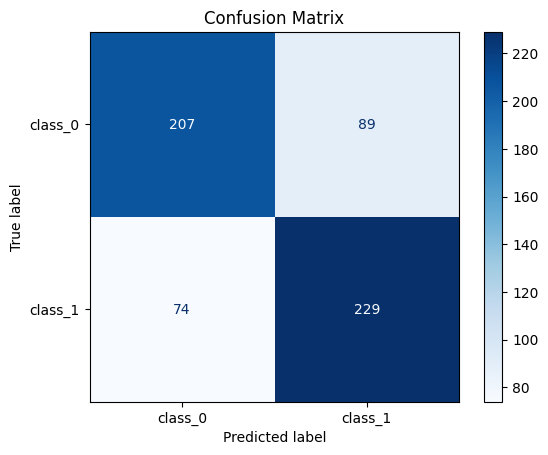

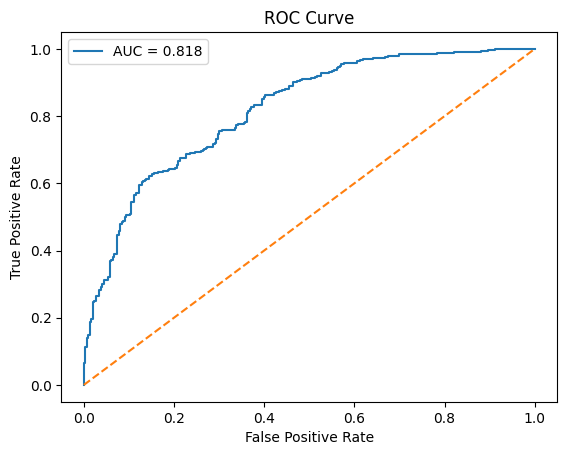

              precision    recall  f1-score   support

     class_0       0.74      0.70      0.72       296
     class_1       0.72      0.76      0.74       303

    accuracy                           0.73       599
   macro avg       0.73      0.73      0.73       599
weighted avg       0.73      0.73      0.73       599



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

# --------------------------
# Gather ground-truth and predictions from validation set
# --------------------------
y_true = []
y_probs = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy().astype(int).tolist())
    y_probs.extend(preds.tolist())

y_true = np.array(y_true)
y_probs = np.array(y_probs)

# --------------------------
# Handle class names safely
# --------------------------
try:
    class_names  # check if exists
except NameError:
    if y_probs.ndim == 1 or y_probs.shape[1] == 1:  # binary
        class_names = ["class_0", "class_1"]
    else:  # multi-class
        class_names = [f"class_{i}" for i in range(y_probs.shape[1])]

# --------------------------
# Predictions
# --------------------------
if y_probs.ndim == 1 or y_probs.shape[1] == 1:   # Binary classification
    y_scores = y_probs.ravel()
    y_pred = [1 if s >= 0.5 else 0 for s in y_scores]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

else:   # Multi-class classification
    y_pred = np.argmax(y_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve for each class
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve")
    plt.legend()
    plt.show()

# --------------------------
# Classification Report
# --------------------------
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# Colab cell 11
MODEL_PATH = '/content/efficientnet_rvf10k.h5'
model.save(MODEL_PATH)
print("Saved model to", MODEL_PATH)

# Copy to Drive (optional)
from google.colab import drive
drive.mount('/content/drive')
!cp /content/efficientnet_rvf10k.h5 /content/drive/MyDrive/
print("Copied model to your Google Drive (MyDrive).")


Saved model to /content/efficientnet_rvf10k.h5
Mounted at /content/drive
Copied model to your Google Drive (MyDrive).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


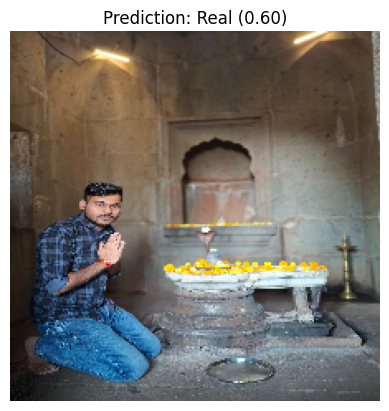

('Real', np.float32(0.59531087))

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Function to test an image
# --------------------------
def predict_image(img_path, model, class_names=None, img_size=(224, 224)):
    # Load and preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    preds = model.predict(img_array)

    # Binary classification
    if preds.shape[1] == 1:
        prob = preds[0][0]
        label = "Fake" if prob >= 0.5 else "Real"
        confidence = prob if prob >= 0.5 else 1 - prob

    # Multi-class classification
    else:
        idx = np.argmax(preds[0])
        label = class_names[idx] if class_names is not None else f"class_{idx}"
        confidence = preds[0][idx]

    # Show result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {label} ({confidence:.2f})")
    plt.show()

    return label, confidence

# --------------------------
# Example usage
# --------------------------
# Replace with your test image path

test_img = "/content/SAVE_20250324_223346.jpg"
predict_image(test_img, model, class_names, img_size=(224, 224))
